# Image classification with CNN

<a name='import'></a>
## 1. Importing

In [1]:
#!pip install piexif

In [2]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
import piexif

import os
import errno
import shutil

from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

from utils import join_path, rotate_image, plot_transforms, join_path_list


import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

<a name='manip'></a>
## 2. Manipulating training data
### 2.1 Create folders for training and validation data

In [4]:
def join_path(path_1='', path_2=''):
    return os.path.join(path_1, path_2).replace('\\', '/')

def create_folder(path='', folder_name=''):
    try:
        os.mkdir(os.path.join(path, folder_name).replace('\\', '/'))
    except OSError as e:
        if e.errno==errno.EEXIST:
            print('Dierctory not created, already exists')
        else:
            raise

project_path = r'C:\Users\jan\projects\tymbark_ase'
#project_path = r'\content\drive\My Drive\projects\tymbark_ase'

project_path = join_path(project_path)
raw_data = 'original_data'

raw_data_path = join_path(project_path, raw_data)

modeling_data_dir = 'modeling_data'
training_dir = 'train'
validation_dir = 'validation'


modeling_data_path = join_path(project_path, modeling_data_dir)
training_path = join_path(modeling_data_path, training_dir)
validation_path = join_path(modeling_data_path, validation_dir)

classes = os.listdir(raw_data_path)


In [5]:
try:
    shutil.rmtree(modeling_data_path)
except FileNotFoundError:
    pass

create_folder(project_path, 'modeling_data')
create_folder(modeling_data_path, training_dir)
create_folder(modeling_data_path, validation_dir)

for dataset in [training_path, validation_path]:
    for label in classes:
        create_folder(dataset, label)

<a name='copy'></a>
### 2.2 Copy data to folders

In [6]:
def split(files_dir='', split_frac=0.8, seed=None):
    examples = pd.Series(os.listdir(files_dir))
    
    train = examples.sample(frac=split_frac, random_state=seed).to_list()
    val = examples.loc[~examples.isin(train)].to_list()
    
    return train, val


def join_path_list(path='', list_of_paths=[]):
    return [join_path(path, photo) for photo in list_of_paths]


def copy_file_list(list_of_paths=[], dest_dir=''):
    for file in list_of_paths: shutil.copy2(file, dest_dir)
        
        
def copy_split(classes_folders_path='', train_dir='',
               val_dir='', split_frac=0.8, seed=None):
    
    for label in classes:
        
        class_data_path = join_path(classes_folders_path, label)
        
        train_fnames, val_fnames = split(class_data_path, split_frac=split_frac, seed=seed)
        
        train_fpaths = join_path_list(class_data_path, train_fnames)
        val_fpaths = join_path_list(class_data_path, val_fnames)
        
        copy_file_list(train_fpaths, join_path(train_dir, label))
        copy_file_list(val_fpaths, join_path(val_dir, label))
        
        
copy_split(raw_data_path, training_path, validation_path, split_frac=0.7, seed=2)    

<a name='rename'></a>
### 2.3 Rename files

In [7]:
def rename_files(classes_dir_path='', dataset_name=str):
    
    for label in os.listdir(classes_dir_path):
        class_dir = join_path(classes_dir_path, label)
        class_fnames = os.listdir(class_dir)

        
        for file_no, file_name in enumerate(class_fnames, 1):
            os.rename(join_path(class_dir, file_name),
                      join_path(class_dir, dataset_name + '_'  + label + '_' + str(file_no) + file_name[-4:]))

            
rename_files(training_path, 'train')
rename_files(validation_path, 'val')

<a name='explore'></a>
## 3. Exploring data
### 3.1. Basic info
#### 3.1.1. Numer of images in each class for training and validation

In [8]:
for label in classes:
    for dir_name, path in zip([training_dir, validation_dir],
                          [training_path, validation_path]):
        
        image_names = pd.Series(os.listdir(join_path(path, label)))
        no_of_images = image_names.shape[0]
        ex_names = image_names.sample(n=3).to_list()
        
        print(label, '|', dir_name, no_of_images, ex_names)
        #os.listdir(join_path(path, lablel))
        
    if label == classes[-1]: pass
    else: print('\n')

cyt_mie | train 50 ['train_cyt_mie_7.jpg', 'train_cyt_mie_28.JPG', 'train_cyt_mie_40.JPG']
cyt_mie | validation 22 ['val_cyt_mie_4.jpg', 'val_cyt_mie_12.JPG', 'val_cyt_mie_15.JPG']


jab_arb | train 51 ['train_jab_arb_24.jpg', 'train_jab_arb_30.JPG', 'train_jab_arb_49.JPG']
jab_arb | validation 22 ['val_jab_arb_1.jpg', 'val_jab_arb_21.JPG', 'val_jab_arb_4.jpg']


jab_brz | train 50 ['train_jab_brz_46.JPG', 'train_jab_brz_21.jpg', 'train_jab_brz_50.JPG']
jab_brz | validation 22 ['val_jab_brz_12.JPG', 'val_jab_brz_3.jpg', 'val_jab_brz_21.JPG']


jab_mie | train 50 ['train_jab_mie_13.jpg', 'train_jab_mie_41.JPG', 'train_jab_mie_39.JPG']
jab_mie | validation 22 ['val_jab_mie_12.JPG', 'val_jab_mie_19.JPG', 'val_jab_mie_21.JPG']


jab_wis | train 50 ['train_jab_wis_23.jpg', 'train_jab_wis_27.jpg', 'train_jab_wis_8.jpg']
jab_wis | validation 22 ['val_jab_wis_14.JPG', 'val_jab_wis_19.JPG', 'val_jab_wis_18.JPG']


man_mie | train 50 ['train_man_mie_43.JPG', 'train_man_mie_31.JPG', 'train_man_mi

<a id='image_shapes'></a>
#### 3.1.2. Shapes of images, file format, orientation

In [9]:
def chceck_exif(image):
    
    try:
        orientation = piexif.load(image.info['exif'])['0th'][piexif.ImageIFD.Orientation]
    except KeyError:
        orientation = 'no data'
    finally:
        return orientation
        

def count_shapes(labels_dirs_path=''):
    
    columns = ['width', 'height', 'channels', 'format', 'orientation']
    shapes_df = pd.DataFrame(np.zeros(len(columns)), index=columns).T

    labels = os.listdir(labels_dirs_path)
    
    for label in labels:
        
        label_path = join_path(labels_dirs_path, label)
        fnames = os.listdir(label_path)
        fpaths = join_path_list(label_path, fnames)
        
        for fpath in fpaths:
            
            image = Image.open(fpath)
            shape = image.size
            mode = image.mode
            file_format = image.format
            orientation = chceck_exif(image)

            image_info = list(shape)
            image_info = image_info + [mode, file_format, orientation]
            iamge_info = pd.DataFrame(image_info, index=columns).T
            
            shapes_df = pd.concat([shapes_df, iamge_info])
            
    shapes_df.reset_index(inplace=True, drop=True)
    shapes_df = shapes_df.iloc[1:, :]
    shapes_df['count'] = 1
    shapes_df = shapes_df.groupby(columns).sum().reset_index()
        
    return shapes_df
        
    
print('Traing images info:')
display(count_shapes(training_path))
print('Validation images info:')
display(count_shapes(validation_path))

Traing images info:


,width,height,channels,format,orientation,count
0,3264,2448,RGB,JPEG,6,24
1,3840,2160,RGB,JPEG,6,173
2,4608,3456,RGB,JPEG,6,154


Validation images info:


,width,height,channels,format,orientation,count
0,3264,2448,RGB,JPEG,6,3
1,3840,2160,RGB,JPEG,6,97
2,4608,3456,RGB,JPEG,6,54


<a id='img_plot'></a>
### 3.2 Ploting examples of images

In [10]:
def rotate_image(image_path, rotations=3):
    
    im = mpimg.imread(image_path)
    rgb = []
    
    for channel in range(im.shape[2]):
        im_channel = im[:, :, channel]
        im_channel = np.rot90(im_channel, rotations)
        rgb.append(im_channel)
 
    rotated_im = np.dstack((rgb[0], rgb[1], rgb[2]))
    
    return rotated_im



def plot_example_images(rows=3, samples=4, classes_dirs_path='', labels=[],
                        figsize=[14, 8], rotations=3):
    
    fig, axs = plt.subplots(nrows=rows, ncols=samples, figsize=figsize)
    
    row = 0
    
    for label in labels:
        label_path = join_path(training_path, label)
        images_paths = pd.Series(join_path_list(
                            label_path,
                            os.listdir(label_path))).sample(samples).to_list()
        
        
        for image_index, image, in enumerate(images_paths):
            
            im = mpimg.imread(image)
            
            if pd.Series([rotations]).isin([1, 2, 3]).values[0]:
                im = rotate_image(image, rotations=rotations)
            
            axs[row][image_index].imshow(im)
            axs[row][image_index].axis('off')  
            
        row += 1
            
    plt.show()

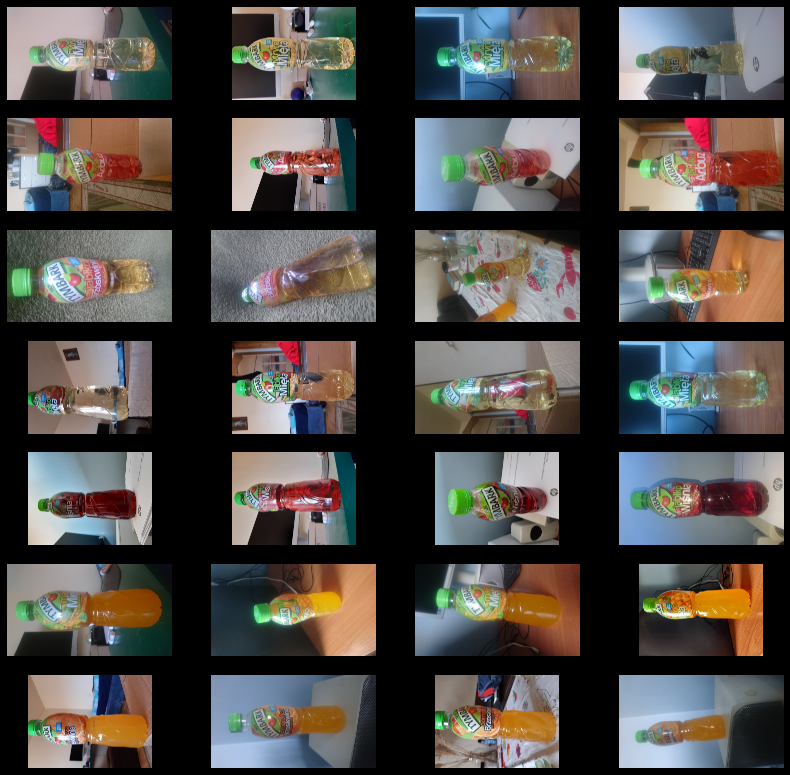

Rotated images


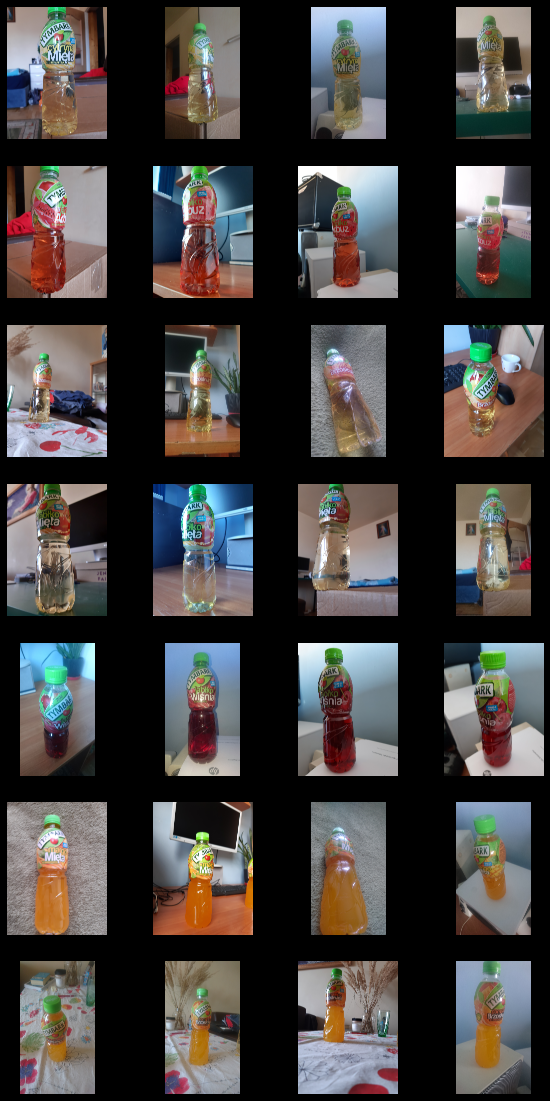

In [11]:
paths = plot_example_images(rows=len(classes), samples=4, classes_dirs_path=training_path,
                            labels=classes, figsize=[14, 14], rotations=0)

print('Rotated images')

paths = plot_example_images(rows=len(classes), samples=4, classes_dirs_path=training_path,
                            labels=classes, figsize=[10, 20], rotations=3)

<a id='preprocess'></a>
## 4. Data preprocessing
### 4.1 Reshape images

In [12]:
target_shape = [256, 256]

def resize_images(classes_dirs_path='', shape=target_shape):
    for label in os.listdir(classes_dirs_path):
        class_dir_path = join_path(classes_dirs_path, label)
        images_paths = join_path_list(class_dir_path, os.listdir(class_dir_path))
    
        for image in images_paths:
            Image.open(image).resize(shape).save(image)
    
    
resize_images(training_path)
resize_images(validation_path)    

<a id='rotate'></a>
### 4.2 Rotate images

In [13]:
def rotate_and_save(classes_dirs_path='', rotations=3):
    
    for folder in os.listdir(classes_dirs_path):
        labels_folder = join_path(classes_dirs_path, folder)
        labels_paths = join_path_list(labels_folder, os.listdir(labels_folder))
        
        for im_path in labels_paths:
            rotated_im = rotate_image(im_path, rotations=rotations)
            Image.fromarray(rotated_im).save(im_path)

            
rotate_and_save(training_path)
rotate_and_save(validation_path)

In [14]:
print('Traing images info:')
display(count_shapes(training_path))
print('Validation images info:')
display(count_shapes(validation_path))

Traing images info:


,width,height,channels,format,orientation,count
0,256,256,RGB,JPEG,no data,351


Validation images info:


,width,height,channels,format,orientation,count
0,256,256,RGB,JPEG,no data,154


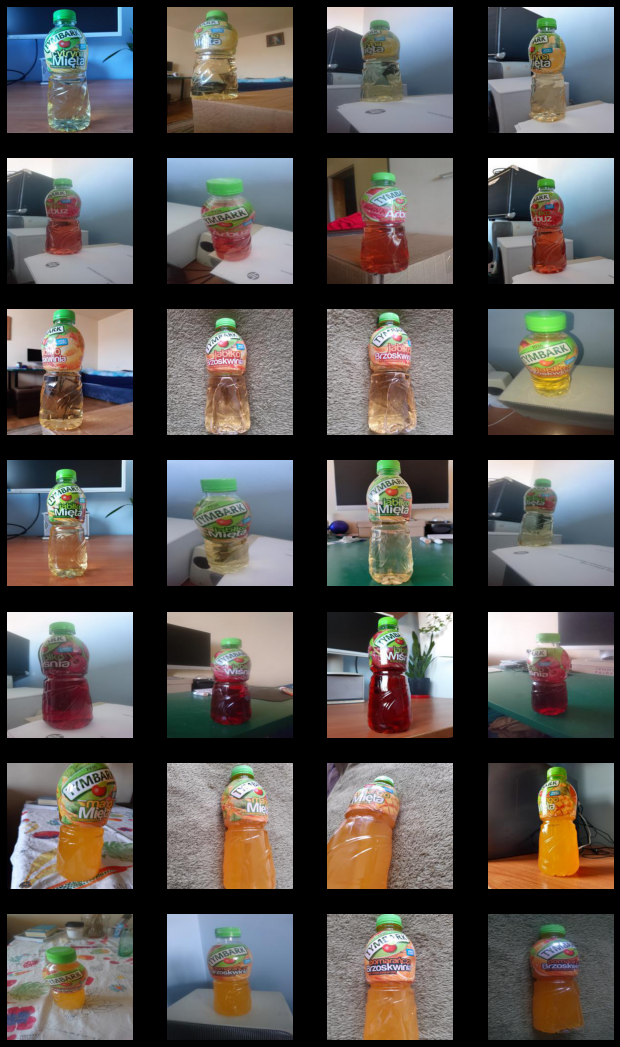

In [15]:
plot_example_images(rows=len(classes), samples=4, classes_dirs_path=validation_path,
                    labels=classes, figsize=[11, 19], rotations=0)

<a id='idg'></a>
### 4.3 Defining ImageDataGenerator

In [16]:
#target_shape = [256, 256]

train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=60,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='constant',
        cval=90,
        brightness_range=(0.80, 1.20),
        shear_range=10,
        zoom_range=0.1,
        channel_shift_range=30,
        zca_whitening=False,
        horizontal_flip=False,
        vertical_flip=False)

#train_datagen = ImageDataGenerator(
#        rescale=1/255)

validation_datagen = ImageDataGenerator(
        rescale=1/255)


train_gen = train_datagen.flow_from_directory(
        training_path,
        target_size=target_shape,
        batch_size=27,
        class_mode='categorical')

validation_gen = validation_datagen.flow_from_directory(
        validation_path,
        target_size=target_shape,
        batch_size=22,
        class_mode='categorical')

Found 351 images belonging to 7 classes.
Found 154 images belonging to 7 classes.


<a id='modeling'></a>
## 5. Modeling
### 5.1 Defining model

In [30]:
model = Sequential()

model.add(Conv2D(64, [3, 3], activation='relu', input_shape=target_shape + [3]))
model.add(MaxPooling2D(2, 2))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))


model.add(Conv2D(128, [3, 3], activation='relu'))
model.add(MaxPooling2D(2, 2))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))


model.add(Conv2D(256, [3, 3], activation='relu'))
model.add(MaxPooling2D(2, 2))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))


model.add(Conv2D(512, [3, 3], activation='relu'))
model.add(MaxPooling2D(2, 2))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
          
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(len(classes), activation='softmax'))

In [31]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        desired_acc = np.round(60 / 60, 2)
        
        if logs['val_accuracy'] >= desired_acc:
            print('Reached', desired_acc, 'accuracy, stopping training')
            self.model.stop_training = True

In [32]:
adam_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 512)      

<a id='training'></a>
### 5.2 Training

In [33]:
%%time
epochs = 100
stop_train_acc = MyCallback()


history = model.fit(
    train_gen, validation_data=validation_gen, epochs=epochs, verbose=2,
    callbacks=[])

Epoch 1/100
13/13 - 9s - loss: 2.0249 - accuracy: 0.1966 - val_loss: 1.9297 - val_accuracy: 0.2078
Epoch 2/100
13/13 - 8s - loss: 1.7863 - accuracy: 0.2678 - val_loss: 1.9077 - val_accuracy: 0.2792
Epoch 3/100
13/13 - 8s - loss: 1.5347 - accuracy: 0.3875 - val_loss: 1.8783 - val_accuracy: 0.4221
Epoch 4/100
13/13 - 8s - loss: 1.3842 - accuracy: 0.4103 - val_loss: 1.8480 - val_accuracy: 0.3896
Epoch 5/100
13/13 - 8s - loss: 1.2166 - accuracy: 0.4530 - val_loss: 1.8047 - val_accuracy: 0.4545
Epoch 6/100
13/13 - 8s - loss: 1.1208 - accuracy: 0.5499 - val_loss: 1.7810 - val_accuracy: 0.3831
Epoch 7/100
13/13 - 8s - loss: 1.1487 - accuracy: 0.4957 - val_loss: 1.7711 - val_accuracy: 0.4481
Epoch 8/100
13/13 - 8s - loss: 0.9201 - accuracy: 0.5926 - val_loss: 1.7060 - val_accuracy: 0.4545
Epoch 9/100
13/13 - 8s - loss: 0.8803 - accuracy: 0.6211 - val_loss: 1.6849 - val_accuracy: 0.4221
Epoch 10/100
13/13 - 8s - loss: 0.8731 - accuracy: 0.6011 - val_loss: 1.6713 - val_accuracy: 0.4221
Epoch 11/

## 6. Model evaluation
### 6.1 Loss and accuracy plot

In [34]:
def process_history(history):
    
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = range(1, history_df.shape[0] + 1)
    
    melt = history_df.melt(id_vars=['epoch'], var_name='metric')
    
    melt['dataset'] = 'training'
    melt.loc[melt['metric'].str.find('val')!=-1, 'dataset'] = 'validation'
    
    melt.loc[melt['metric'].str.find('loss')!=-1, 'metric'] = 'loss'
    melt.loc[melt['metric'].str.find('accuracy')!=-1, 'metric'] = 'accuracy'
    
    return melt


def append_history(new_history, old_history_df, old_history=False):
    
    new_history_df = process_history(new_history)
    
    if old_history:
        
        new_history_df['epoch'] = new_history_df['epoch'] + old_history_df['epoch'].max()
        new_history_df = pd.concat([old_history_df, new_history_df], axis=0)
        
        return new_history_df
   
    return new_history_df

In [35]:
#del(history_df)

In [36]:
if 'history_df' in globals():
    history_df = append_history(new_history=history,
                                old_history_df=history_df,
                                old_history=True)
else:
    history_df = append_history(new_history=history,
                                old_history_df=False)
    
#history_df = append_history(new_history=history,
#                               old_history_df=False)

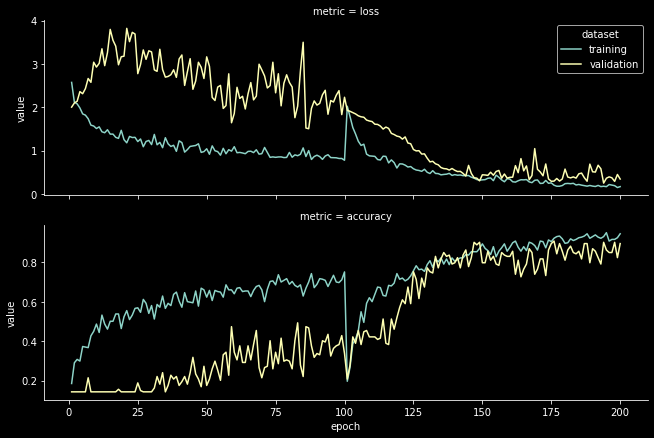

In [37]:
#t = history_df.loc[history_df['epoch']>50]
t = history_df.copy()

sns.relplot(data=t, x='epoch', y='value', row='metric', hue='dataset',
            kind='line', aspect=3, height=3,
            facet_kws={'sharey': False, 'legend_out': False})
plt.show()

### 6.2 Score on training and validation set

In [38]:
eval_train_datagen = ImageDataGenerator(rescale=1/255)
eval_validation_datagen = ImageDataGenerator(rescale=1/255)

eval_train = eval_train_datagen.flow_from_directory(
        training_path,
        target_size=target_shape,
        batch_size=24,
        class_mode='categorical',
        shuffle=False)

eval_validation = eval_validation_datagen.flow_from_directory(
        validation_path,
        target_size=target_shape,
        batch_size=12,
        class_mode='categorical',
        shuffle=False)


train_score = np.round(model.evaluate(eval_train, verbose=3), 2)
val_score = np.round(model.evaluate(eval_validation, verbose=3), 2)

print('\n')
print(f'Train_score:      loss = {train_score[0]}, accuracy = {train_score[1]}')
print(f'Validation_score: loss = {val_score[0]}, accuracy = {val_score[1]}')

Found 351 images belonging to 7 classes.
Found 154 images belonging to 7 classes.


Train_score:      loss = 0.05, accuracy = 0.98
Validation_score: loss = 0.34, accuracy = 0.9


### 6.3 Ploting misclassified images

In [39]:
def predictons_df(image_generator, model):
    
    class_names = image_generator.class_indices.keys()
    

    proba_df = pd.DataFrame(
                    model.predict(image_generator),
                    columns=class_names)

    proba_df['correct_pred'] = ((np.argmax(model.predict(image_generator), axis=1) \
                                 ==image_generator.labels) + 0).astype(np.uint8)
    
    proba_df['pred_proba'] = model.predict(image_generator).max(axis=1)
    
    proba_df['file_path'] = pd.Series(image_generator.filepaths).astype('string')
    
    
    labels_dict = {v: k  for k, v in image_generator.class_indices.items()}
    
    proba_df['correct_label'] = pd.Series(image_generator.labels).map(labels_dict)
    
    proba_df.loc[:, class_names] = proba_df.loc[:, class_names].round(2)
    proba_df.loc[:, 'pred_proba'] = proba_df.loc[:, 'pred_proba'].round(2)
    
    return proba_df


df = predictons_df(eval_train, model)

In [40]:
def plot_missclassified(image_generator, model, height=20, missclass=True):
    if missclass:
        pred_df = predictons_df(image_generator, model) \
                    .loc[lambda df: df['correct_pred']==0]
    else:
        pred_df = predictons_df(image_generator, model)
    
    columns = 3
    rows = int(np.ceil(pred_df.shape[0] / columns))
    
    width = 14
    #height = (70 / 14) * width
    
    fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(width, height))
    axs = axs.flatten()
    
    for ax, example in enumerate(pred_df.iterrows()):
        fp = example[1]['file_path']
        axs[ax].imshow(mpimg.imread(fp))
        axs[ax].axis('off')
        
        labels = pred_df.columns[pred_df.columns.isin(classes)]
        
        #return example[1][labels]
        #break
        
        for label, proba, y in zip(labels, example[1][labels], range(0, 20*len(labels), 20)):
            #print(example[0])
            
            #print(pred_df.loc[example[1]])
            
            if label==pred_df.loc[example[0], 'correct_label']:
                color = 'green'
            elif proba==pred_df.loc[example[0], 'pred_proba']:
                color = 'red'
            else:
                color = 'white'
            
            
            axs[ax].annotate(f'\n{label}:', [256, 12 + y],
                             color=color, size=15.5, weight=240)
            
            axs[ax].annotate(f'{proba:21.2f}', [256, 12 + y],
                             color=color, size=15.5, weight=240)
            
        
            
        for row in pred_df.iterrows():
            for label in labels: pass
                #print(label, row[1][label])
    
    for ax in axs: ax.axis('off')
    
    plt.tight_layout()
    
    return axs

#### 6.3.1 Misclassified on training set

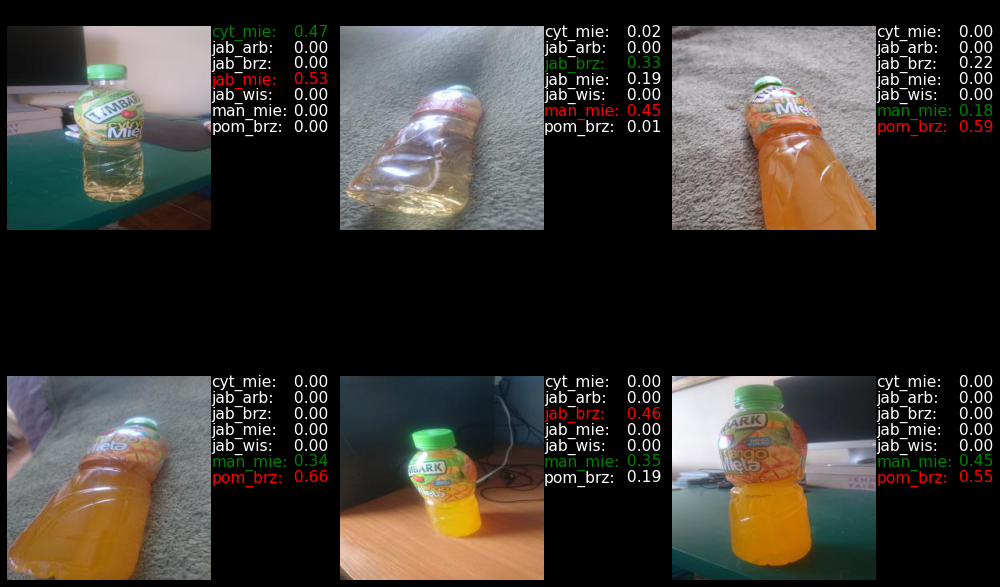

In [46]:
axs = plot_missclassified(eval_train, model, height=10)

#### 6.3.2 Misclassified on validation set

In [ ]:
axs = plot_missclassified(eval_validation, model, height=26)